## This notebook is for the classification section of the book

In [2]:
#read the mnist dataset
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

The following code is for extracting the inputs and outputs of the model. 

In [3]:
X, y = mnist['data'].to_numpy(), mnist['target'].astype(np.uint8)

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
from matplotlib import pyplot as plt


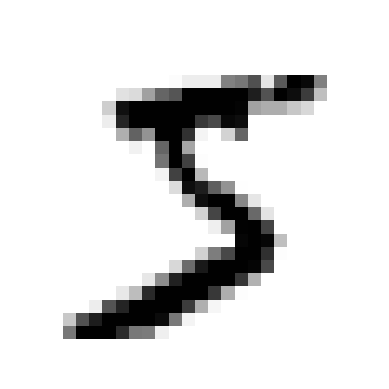

In [6]:
some_digit = X[0]
some_image = some_digit.reshape(28,28)
plt.imshow(some_image, cmap = 'binary')
plt.axis('off')
plt.show()

Now we have to split the dataset into training and testing parts. The first 60000 images are used for training, while the last 10000 are used for testing.
The training data is already shuffled, so we don't need to do that.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classification
Before we try to do full classification, we will experiment with building a classifier that distinguishes between the digit 5 and all other digits.

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now we build the SGD classifier, which uses a linear SVM

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

Check the model's performance using cross validation and stratified cross validation

In [11]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import clone

In [12]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train[train_index]
    X_test_fold = X_train[test_index]
    y_train_fold = y_train_5[train_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


Now we use the confusion matrix as a better preformance measure

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

This following function (cross_val_predict) splits the training data into (cv) splits, where one fold is used for prediction, and the rest is used for training. 
The function trains a classifier on the training splits and uses it to predict the values of the data used for testing. In this way, since in the code below we used cv = 3, the function will train 3 classifiers, each one of them will be used to calculate the predictions of a third of the data. 
The function returns the predictions classes. If you want it to return the scores for each instance, you can call the function like this:

y_train_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [15]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [16]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Precision is equal to: TP/(TP+FP)
In other words, the precision is equal to how many true positives there are, divided by the total number of positives in the dataset.

Recall is equal to: TP/(TP+FN)
In other wortds, it measures the fraction of the instances that are correctly detected by the classifier.

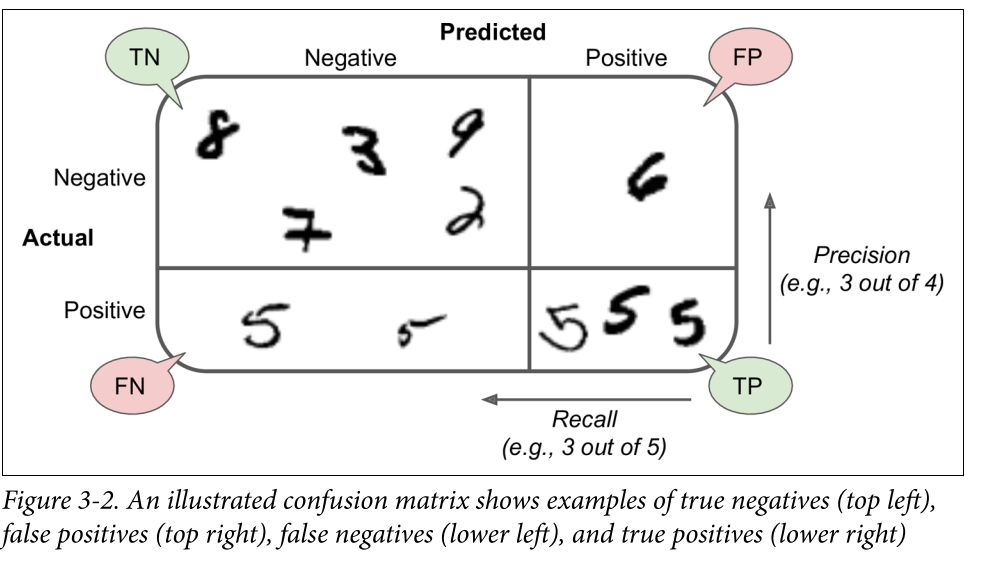

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

The results above can be interpreted as follows:
1. When the model claims that the input is a 5, it is correct 83.708% of the time. (This is the precision of the model)
2. The model detects only 65.11% of the 5's. (This is the recall of the model)

You can combine both the precision and recall into a single measure that is called the F1 score. It can be calculated as follows:

F1 = 2 * (precision * recall) / (precision + recall)

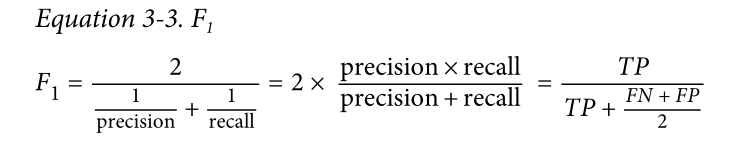

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

Do determine the best threshold to use for classification, we can plot different ranges of thresholds and see how the precision and recall socres change for each threshold. Then, we can pick the point at which both curves meet as the best threshold for both the precision and recall.

precision_recall_curve returns n+1 samples, so we have to remove the last one in order to plot the result

In [33]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, 
                             method = 'decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
precisions = precisions[:-1]
recalls = recalls[:-1]

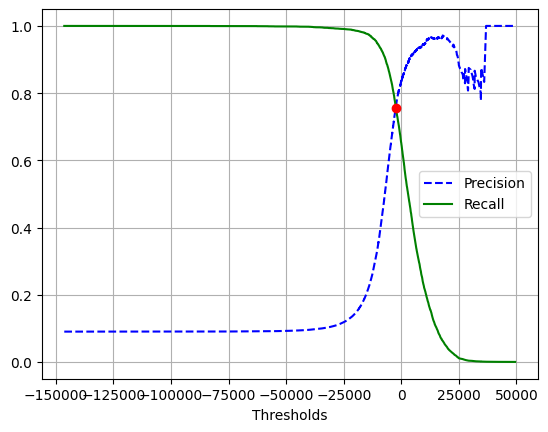

array([-2379.06450093])

In [39]:
plt.plot(thresholds, precisions, 'b--', label = 'Precision')
plt.plot(thresholds, recalls, 'g-', label = 'Recall')
plt.plot(thresholds[precisions == recalls], precisions[precisions == recalls], '-ro')
plt.legend()
plt.grid()
plt.xlabel('Thresholds')
plt.show()
best_threshold = thresholds[precisions == recalls]
best_threshold

The precision curve looks bumpy becuase as the threshold increases, the precision tends to generally increase, but it can decrease at some points. On the other hand, the recall curve can only go down as the threshold is increased. 
Check the following figure for explanation:

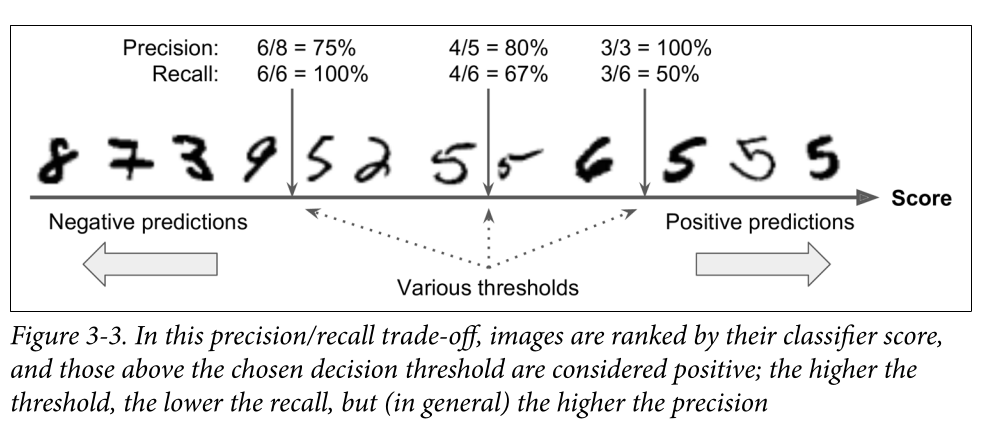

We can also plot the precision against the recall directly like this:

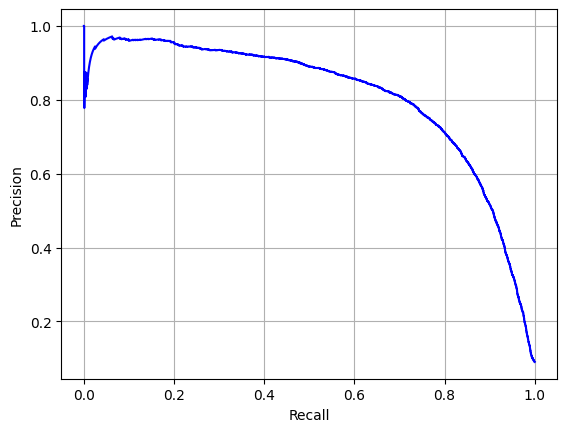

In [40]:
plt.plot(recalls, precisions, '-b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

The ROC curve (Receiver Operating Charactersitc) curve is another tool that is commonly used with binary classifiers. It is similar to the precision/recall curve, but instead of plotting the precision against the recall, it plots the TPR (True Positive Rate), which is another name for the recall, against the FPR (False Positive Rate).

$TPR = Recall = TP/(TP + FN)$

$FPR = 1-TNR = 1-Specificity = FP/(TN + FP)$

In [41]:
from sklearn.metrics import roc_curve

In [42]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

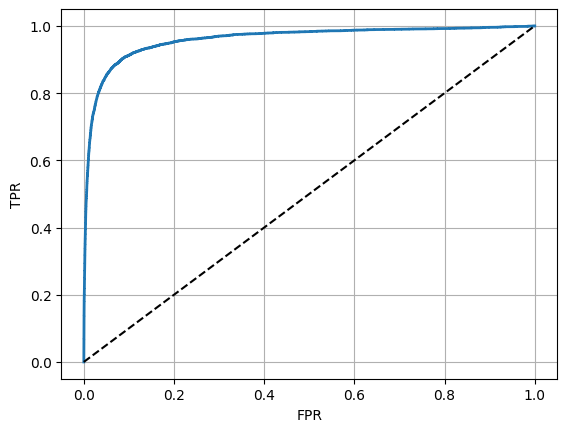

In [43]:
plt.plot(fpr, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

We can also calculate the area under the curve to compare classifiers to each other as follows:

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

When to use the Precision/Recall curve vs ROC curve?

Choose the PR curve when:
1. When the positive class is rare
2. When you care about the false positives more than the false negatives.

Otherwise, you should choose the ROC curve.

Let us now train a random forest classsifier and compare it to the sgd classifier.

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')


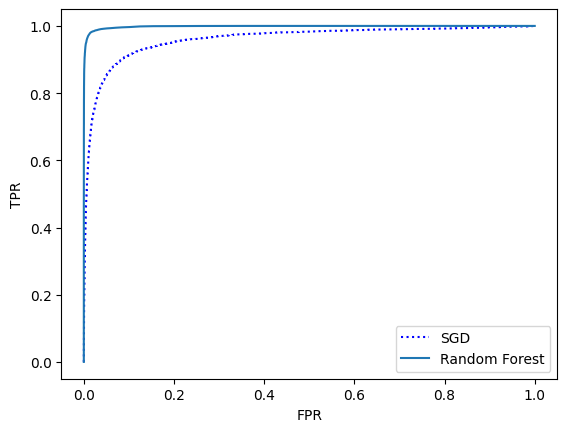

In [49]:
y_scores_forest = y_probas_forest[:, 1] # get the probability of the positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label = 'SGD')
plt.plot(fpr_forest, tpr_forest, label = 'Random Forest')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

In [51]:
{'Random Forest' : roc_auc_score(y_train_5, y_scores_forest), 'SGD' : roc_auc_score(y_train_5, y_scores)}

{'Random Forest': 0.9983436731328145, 'SGD': 0.9604938554008616}

# Multiclass Classification

__One-versus-the-rest__
1. For each class in the dataset, train a classifier that specializes in detecting that class and rejecting all other classes.
2. When you want to get the output, you pass the input to each classifier and select the class whose output is the highest as the label for the input.

__One-versus-one__
1. Train a classifier that can distinguish between every possible pair of classes. For example, A (0s and 1s) classifier, a (0s and 2s) classifier, a (1s and 2s) classifier, and so on. In this situation, you would need a number equal to $N*(N-1)/2$ classifiers, where $N$ is the number of classes in the problem.
2. when you want to get the output, you pass the input to all the classifiers and select the class that wins most duels as the output of the model. 

The advantage of OvO over OvR is that each classifier needs to be trained only on a pair of classes instead of the whole dataset. 

This can be useful with Support Vector Classifiers since they scale poorly with the size of the training set. Therefore, the OvO strategy is preferred when using SVCs. 

However, for most other types of classification algorithms, the OvR strategy is preferred.

__Note:__
 Scikit-learn detects when you want to use a binary classification algorithm with a multiclass database, and it automatically chooses to run OvR or OvO depending on the algorithm used.

In [52]:
from sklearn.svm import SVC

In [53]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train) #multiclass labels
svm_clf.predict([some_digit])


array([5], dtype=uint8)

In [55]:
some_digit_scores = svm_clf.decision_function([some_digit]) # get the scores of each class

In [56]:
np.argmax(some_digit_scores)

5

In this case, scikit-learn used the OvO strategy to train the svm. 

If you want sciki-learn to use OvR instead, you can do the following:

In [57]:
from sklearn.multiclass import OneVsRestClassifier

In [58]:
ovr_clf = OneVsRestClassifier(SVC())

In [59]:
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [60]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [62]:
len(ovr_clf.estimators_)

10

The SGD classifier doesn't need OvO or OvR because it can handle multiple classes natively. 

In [66]:
sgd_clf = SGDClassifier(n_jobs = 4)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [68]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring = 'accuracy', n_jobs = 6)

array([0.85445, 0.85875, 0.8621 ])

You can improve the score by simply scaling the data as follows:

In [69]:
from sklearn.preprocessing import StandardScaler

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy', n_jobs = 4)

/home/thoalfeqar/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.90315, 0.89405, 0.90185])